<a href="https://colab.research.google.com/github/torayeff/RoboCupHumanoid/blob/master/Sweaty1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q torch==1.0.0 torchvision

## Clone repository, organize data into folder

In [ ]:
!git clone https://github.com/torayeff/RoboCupHumanoid.git
!mv RoboCupHumanoid/* .
!rm RoboCupHumanoid/ -rf
!mkdir data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp drive/'My Drive'/labivision/data/train.zip data/
!unzip -q data/train.zip -d data/
!rm data/train.zip

In [1]:
from conv_lstm import ConvLSTMCell
import torch
import torch.nn as nn
import utils as utils
from SweatyNet1 import SweatyNet1
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak
import matplotlib.cm as cm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Testing ConvLstm

In [2]:
modelPath = ''

model = SweatyNet1(use_conv_lstm=True, device=device)
model.to(device)

if modelPath != '':
    print("Loading Sweaty")
    model.load_state_dict(torch.load(modelPath, map_location='cpu'))
print(model)

SweatyNet1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU

In [3]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

trainset = utils.SoccerBallDataset("data/train/data.csv", "data/train", downsample=4)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

Computing teacher signals...
Elapsed: 3.958415 sec.


In [12]:
utils.evaluate_model(model, device, trainset)

{'tps': 247, 'fps': 71, 'tns': 0, 'fns': 35}

In [8]:
conv_lstm = ConvLSTMCell(1, 1, 1, device)

1 120 160


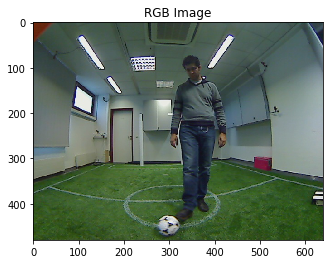

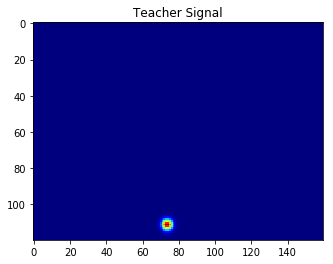

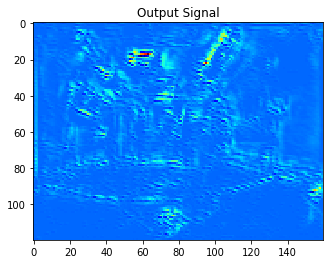

In [4]:
idx = 51
image = trainset[idx]['image']
signal = np.array(trainset[idx]['signal'].squeeze())

output, c_t = model(image.unsqueeze(0).float().to(device), None, None)

output_signal = np.array(output.cpu().squeeze().detach())

plt.title("RGB Image")
plt.imshow(np.array(image).transpose(1, 2, 0))
plt.show()

plt.title("Teacher Signal")
plt.imshow(signal, cmap=cm.jet)
plt.show()


plt.title("Output Signal")
plt.imshow(output_signal, cmap=cm.jet)
plt.show()

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(extended_model.parameters())

(tensor([[[[0.0361, 0.3528, 0.2020,  ..., 0.3339, 0.0066, 0.2983],
           [0.0000, 0.3246, 0.3904,  ..., 0.0000, 0.0000, 0.1832],
           [0.0796, 0.5788, 1.1139,  ..., 0.0802, 0.0000, 0.0000],
           ...,
           [0.1191, 0.1752, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.7589, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.2875, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0382]]]],
        grad_fn=<ThresholdBackward0>), None, None)

In [7]:
epochs = 1

seq_len = 6
signals_stack = None
outputs_stack = None
h_t = None
c_t = None

for epoch in range(epochs):
    epoch_loss = 0
    tic = time.time()
    for i, data in enumerate(trainloader):
            
        if i % seq_len == 0:
            optimizer.zero_grad()

        images = data['image'].float().to(device)
        signals = data['signal'].float().to(device)
        
        if signals_stack is None and outputs_stack is None:
            signals_stack = torch.zeros(seq_len, signals.size(0), signals.size(1), signals.size(2), signals.size(3))
            outputs_stack = torch.zeros(seq_len, signals.size(0), signals.size(1), signals.size(2), signals.size(3))
        
        h_t, c_t = model(images, h_t, c_t)
        
        signals_stack[i % seq_len] = signals
        outputs_stack[i % seq_len] = h_t
        
        if i+1 % seq_len == 0: 
            loss = criterion(signals_stack, outputs_stack)

            loss.backward()
            optimizer.step()
            
        
            epoch_loss += loss.item()
            break
    
    epoch_loss /= len(trainset)
    epoch_time = time.time() - tic
    print("Epoch: {}, loss: {}, time: {:.5f} seconds".format(epoch + 1, epoch_loss, epoch_time))
    

Size:  torch.Size([4, 1, 120, 160])
4 120 160
Hidden  torch.Size([4, 2, 120, 160])
conv_output  torch.Size([4, 4, 120, 160])
h_t - >  torch.Size([4, 1, 120, 160])
Size:  torch.Size([4, 1, 120, 160])
Hidden  torch.Size([4, 2, 120, 160])
conv_output  torch.Size([4, 4, 120, 160])
h_t - >  torch.Size([4, 1, 120, 160])
Size:  torch.Size([4, 1, 120, 160])
Hidden  torch.Size([4, 2, 120, 160])
conv_output  torch.Size([4, 4, 120, 160])
h_t - >  torch.Size([4, 1, 120, 160])
Size:  torch.Size([4, 1, 120, 160])
Hidden  torch.Size([4, 2, 120, 160])
conv_output  torch.Size([4, 4, 120, 160])
h_t - >  torch.Size([4, 1, 120, 160])
Size:  torch.Size([4, 1, 120, 160])
Hidden  torch.Size([4, 2, 120, 160])
conv_output  torch.Size([4, 4, 120, 160])
h_t - >  torch.Size([4, 1, 120, 160])
Size:  torch.Size([4, 1, 120, 160])
Hidden  torch.Size([4, 2, 120, 160])
conv_output  torch.Size([4, 4, 120, 160])
h_t - >  torch.Size([4, 1, 120, 160])
Size:  torch.Size([4, 1, 120, 160])
Hidden  torch.Size([4, 2, 120, 160])

KeyboardInterrupt: 